# ResNet50 Image Classifier — MMHS150K Hate Speech Detection
## Google Colab Training Notebook (T4/A100 GPU)

**Architecture:** ResNet50 (ImageNet pretrained) → 2048-dim GAP → Dropout(0.3) → Linear(2, )  
**Training strategy:** 2-phase — freeze backbone for warm-up epochs, then unfreeze full network  
**Dataset:** MMHS150K — 150k tweets with images, binary (NotHate / Hate)

### Steps
1. GPU check + install packages
2. Mount Google Drive
3. Upload dataset files
4. Config
5. Dataset & DataLoaders
6. Model + optimizer
7. Training loop (with early stopping + Drive checkpointing)
8. Training curves
9. Test evaluation
10. Confusion matrix + per-class F1
11. Save full model to Drive
12. Inference verification

## Step 1 — GPU Check & Install Packages

In [1]:
import torch, subprocess, platform
print(f"Python  : {platform.python_version()}")
print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU     : {torch.cuda.get_device_name(0)}")
    print(f"VRAM    : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  No GPU detected — switch Runtime to T4 GPU before proceeding")

subprocess.run(["pip", "install", "-q", "torchvision", "tqdm", "scikit-learn",
                "seaborn", "matplotlib", "Pillow"], check=True)
print("\nPackages ready ✓")

Python  : 3.12.12
PyTorch : 2.10.0+cu128
CUDA    : True
GPU     : NVIDIA A100-SXM4-40GB
VRAM    : 42.4 GB

Packages ready ✓


## Step 2 — Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
DRIVE_ROOT = '/content/drive/MyDrive/MMHS150K_CNN'
os.makedirs(DRIVE_ROOT, exist_ok=True)
os.makedirs(f'{DRIVE_ROOT}/checkpoints', exist_ok=True)
os.makedirs(f'{DRIVE_ROOT}/results',     exist_ok=True)
print(f"Drive root: {DRIVE_ROOT}")

Mounted at /content/drive
Drive root: /content/drive/MyDrive/MMHS150K_CNN


## Step 3 — Upload Dataset Files

Upload **`MMHS150K_GT.json`** and the three split files (`train_ids.txt`, `val_ids.txt`, `test_ids.txt`).  
Then upload the **image zip** (`img_resized.zip`) and extract it.
> If you already have these files on Drive, update the paths in the config cell instead.

In [4]:
from google.colab import files

# ── Option A: upload from your computer ──────────────────────────────────────
print("Upload MMHS150K_GT.json + train_ids.txt + val_ids.txt + test_ids.txt")
uploaded = files.upload()
for fname, data in uploaded.items():
    with open(f'/content/{fname}', 'wb') as f:
        f.write(data)
    print(f"  Saved /content/{fname}  ({len(data)/1e6:.1f} MB)")

# ── Option B: if files already live on Drive, skip upload and set paths below ─
# GT_FILE   = f'{DRIVE_ROOT}/MMHS150K_GT.json'
# TRAIN_IDS = f'{DRIVE_ROOT}/train_ids.txt'
# VAL_IDS   = f'{DRIVE_ROOT}/val_ids.txt'
# TEST_IDS  = f'{DRIVE_ROOT}/test_ids.txt'

Upload MMHS150K_GT.json + train_ids.txt + val_ids.txt + test_ids.txt


Saving train_ids.txt to train_ids.txt
Saving test_ids.txt to test_ids.txt
Saving val_ids.txt to val_ids.txt
Saving MMHS150K_GT.json to MMHS150K_GT (1).json
  Saved /content/train_ids.txt  (2.7 MB)
  Saved /content/test_ids.txt  (0.2 MB)
  Saved /content/val_ids.txt  (0.1 MB)
  Saved /content/MMHS150K_GT (1).json  (51.4 MB)


In [6]:
import zipfile, os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to zip file in My Drive
ZIP_PATH = '/content/drive/MyDrive/img_resized.zip'   # adjust if inside a folder
IMG_DIR  = '/content/img_resized'

# Extract only if not already extracted
if not os.path.exists(IMG_DIR):
    print("Extracting images from Drive...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall('/content/')
    print(f"Done — {len(os.listdir(IMG_DIR)):,} images")
else:
    print(f"Already extracted — {len(os.listdir(IMG_DIR)):,} images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting images from Drive...
Done — 150,000 images


## Step 4 — Config  *(edit these before running)*

In [7]:
# ── Data paths ────────────────────────────────────────────────────────────────
GT_FILE   = '/content/MMHS150K_GT.json'
TRAIN_IDS = '/content/train_ids.txt'
VAL_IDS   = '/content/val_ids.txt'
TEST_IDS  = '/content/test_ids.txt'
IMG_DIR   = '/content/img_resized'      # folder with {tweet_id}.jpg files

# ── Training hyperparameters ──────────────────────────────────────────────────
EPOCHS        = 5        # total epochs
FREEZE_EPOCHS = 2        # train only head for first N epochs, then unfreeze backbone
BATCH_SIZE    = 64       # T4 has 16GB VRAM — 64 is safe
LR            = 1e-4     # head learning rate
BACKBONE_LR   = 1e-5     # backbone LR after unfreezing
DROPOUT       = 0.3
PATIENCE      = 2        # early stopping: stop if val F1 doesn't improve for N epochs
BINARY        = True     # True = NotHate vs Hate  |  False = 6-class
NUM_WORKERS   = 2

# ── Output ────────────────────────────────────────────────────────────────────
TASK_TAG    = 'binary' if BINARY else '6class'
N_CLASSES   = 2 if BINARY else 6

LABEL_MAP_BINARY = {0: 'NotHate', 1: 'Hate'}
LABEL_MAP_6 = {0: 'NotHate', 1: 'Racist', 2: 'Sexist', 3: 'Homophobe', 4: 'Religion', 5: 'OtherHate'}
LABEL_MAP   = LABEL_MAP_BINARY if BINARY else LABEL_MAP_6
LABEL_NAMES = [LABEL_MAP[i] for i in range(N_CLASSES)]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device    : {DEVICE}")
print(f"Task      : {TASK_TAG}  ({N_CLASSES} classes: {LABEL_NAMES})")
print(f"Epochs    : {EPOCHS}  (freeze_epochs={FREEZE_EPOCHS}, patience={PATIENCE})")
print(f"Batch     : {BATCH_SIZE}  |  LR(head)={LR}  LR(backbone)={BACKBONE_LR}")

Device    : cuda
Task      : binary  (2 classes: ['NotHate', 'Hate'])
Epochs    : 5  (freeze_epochs=2, patience=2)
Batch     : 64  |  LR(head)=0.0001  LR(backbone)=1e-05


## Step 5 — Dataset & DataLoaders

In [8]:
import json
from collections import Counter
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

# ── Transforms ────────────────────────────────────────────────────────────────
_MEAN = [0.485, 0.456, 0.406]
_STD  = [0.229, 0.224, 0.225]

TRAIN_TF = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(_MEAN, _STD),
])
EVAL_TF = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(_MEAN, _STD),
])

# ── Dataset class ─────────────────────────────────────────────────────────────
def majority_vote(labels):
    return Counter(labels).most_common(1)[0][0]

class MMHS150KImageDataset(Dataset):
    def __init__(self, ids, gt, img_dir, transform, binary=True):
        self.img_dir   = Path(img_dir)
        self.transform = transform
        self.binary    = binary
        self.samples   = []
        self.skipped   = 0
        for tid in ids:
            item = gt.get(tid)
            if item is None: self.skipped += 1; continue
            img_path = self.img_dir / f"{tid}.jpg"
            if not img_path.exists(): self.skipped += 1; continue
            labs = item.get('labels', [])
            if not (isinstance(labs, list) and len(labs) >= 1): self.skipped += 1; continue
            while len(labs) < 3: labs = labs + [labs[-1]]
            labs = [int(x) for x in labs[:3]]
            y6 = majority_vote(labs)
            y  = (0 if y6 == 0 else 1) if binary else y6
            self.samples.append((str(img_path), y))

    def __len__(self):  return len(self.samples)
    def __getitem__(self, idx):
        path, y = self.samples[idx]
        try:    img = Image.open(path).convert('RGB')
        except: img = Image.new('RGB', (224, 224), (0, 0, 0))
        return self.transform(img), torch.tensor(y, dtype=torch.long)

    def class_weights(self):
        counts = Counter(y for _, y in self.samples)
        n = 2 if self.binary else 6
        total = len(self.samples)
        return torch.tensor([total / (n * counts.get(i, 1)) for i in range(n)], dtype=torch.float)

    def sample_weights(self):
        counts = Counter(y for _, y in self.samples)
        return [1.0 / counts[y] for _, y in self.samples]

# ── Load ──────────────────────────────────────────────────────────────────────
print("Loading ground truth...")
with open(GT_FILE, encoding='utf-8') as f:
    gt = json.load(f)

def load_ids(path):
    with open(path) as f: return [l.strip() for l in f if l.strip()]

train_ids = load_ids(TRAIN_IDS)
val_ids   = load_ids(VAL_IDS)
test_ids  = load_ids(TEST_IDS)

train_ds = MMHS150KImageDataset(train_ids, gt, IMG_DIR, TRAIN_TF, BINARY)
val_ds   = MMHS150KImageDataset(val_ids,   gt, IMG_DIR, EVAL_TF,  BINARY)
test_ds  = MMHS150KImageDataset(test_ids,  gt, IMG_DIR, EVAL_TF,  BINARY)

print(f"Train: {len(train_ds):,}  (skipped {train_ds.skipped})")
print(f"Val  : {len(val_ds):,}  (skipped {val_ds.skipped})")
print(f"Test : {len(test_ds):,}  (skipped {test_ds.skipped})")

# Weighted sampler for class balance
sampler = WeightedRandomSampler(train_ds.sample_weights(), len(train_ds), replacement=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# Class distribution
counts = Counter(y for _, y in train_ds.samples)
print("\nTrain class distribution:")
for i in range(N_CLASSES):
    c = counts.get(i, 0)
    print(f"  {LABEL_NAMES[i]:<12}: {c:>7,}  ({c/len(train_ds)*100:5.1f}%)")
print(f"\nClass weights: {train_ds.class_weights().tolist()}")

Loading ground truth...
Train: 134,823  (skipped 0)
Val  : 5,000  (skipped 0)
Test : 10,000  (skipped 0)

Train class distribution:
  NotHate     : 108,460  ( 80.4%)
  Hate        :  26,363  ( 19.6%)

Class weights: [0.6215332746505737, 2.5570497512817383]


## Step 6 — Model + Optimizer

In [9]:
import torch.nn as nn
from torchvision import models

class ResNetImageClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout=0.3, freeze_backbone=True):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_features = backbone.fc.in_features   # 2048
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_features, num_classes))
        if freeze_backbone:
            for p in self.backbone.parameters(): p.requires_grad = False

    def forward(self, x):
        return self.head(self.backbone(x))

    def unfreeze_backbone(self):
        for p in self.backbone.parameters(): p.requires_grad = True

# Build model — start with frozen backbone
model = ResNetImageClassifier(num_classes=N_CLASSES, dropout=DROPOUT, freeze_backbone=True).to(DEVICE)

cw      = train_ds.class_weights().to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=cw)

# Only head params are active initially
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR, weight_decay=1e-4
)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params (head only): {trainable:,} / {total:,}")
print(f"Will unfreeze backbone at epoch {FREEZE_EPOCHS + 1}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]


Trainable params (head only): 4,098 / 23,512,130
Will unfreeze backbone at epoch 3


## Step 7 — Training Loop (Early Stopping + Drive Checkpointing)

In [10]:
import time, shutil
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score

BEST_CKPT  = f'{DRIVE_ROOT}/checkpoints/cnn_{TASK_TAG}_best.pt'
history    = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_f1   = -1.0
patience_ctr  = 0

@torch.no_grad()
def evaluate(loader):
    model.eval()
    preds_all, labels_all, total_loss = [], [], 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = model(imgs)
        total_loss += loss_fn(logits, labels).item()
        preds_all.extend(torch.argmax(logits, 1).cpu().tolist())
        labels_all.extend(labels.cpu().tolist())
    return (total_loss / max(1, len(loader)),
            accuracy_score(labels_all, preds_all),
            f1_score(labels_all, preds_all, average='macro', zero_division=0),
            labels_all, preds_all)

t0_total = time.time()

for epoch in range(1, EPOCHS + 1):

    # ── Phase 2: unfreeze backbone ────────────────────────────────────────
    if epoch == FREEZE_EPOCHS + 1:
        print(f"\n[Epoch {epoch}] Unfreezing backbone — LR backbone={BACKBONE_LR}")
        model.unfreeze_backbone()
        optimizer = torch.optim.AdamW([
            {'params': model.backbone.parameters(), 'lr': BACKBONE_LR},
            {'params': model.head.parameters(),     'lr': LR},
        ], weight_decay=1e-4)
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"  Trainable params: {trainable:,}")

    # ── Train ─────────────────────────────────────────────────────────────
    model.train()
    running_loss, n_correct, n_total = 0.0, 0, 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS}', leave=False)
    for step, (imgs, labels) in enumerate(pbar, 1):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        preds     = torch.argmax(logits, 1)
        n_correct += (preds == labels).sum().item()
        n_total   += labels.size(0)
        pbar.set_postfix(loss=f'{running_loss/step:.4f}', acc=f'{n_correct/n_total:.4f}')

    train_loss = running_loss / len(train_loader)
    train_acc  = n_correct / n_total
    val_loss, val_acc, val_f1, _, _ = evaluate(val_loader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    elapsed = time.time() - t0
    print(f"Epoch {epoch}/{EPOCHS} [{elapsed:.0f}s]  "
          f"train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  "
          f"val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  val_f1={val_f1:.4f}")

    # ── Checkpoint & early stopping ───────────────────────────────────────
    if val_f1 > best_val_f1:
        best_val_f1  = val_f1
        patience_ctr = 0
        torch.save({
            'epoch': epoch, 'model_state': model.state_dict(),
            'val_f1': val_f1, 'config': {
                'num_classes': N_CLASSES, 'dropout': DROPOUT,
                'binary': BINARY, 'task': TASK_TAG,
            }
        }, BEST_CKPT)
        print(f"  ✓ Best model saved to Drive  (val_f1={best_val_f1:.4f})")
    else:
        patience_ctr += 1
        print(f"  No improvement ({patience_ctr}/{PATIENCE})")
        if patience_ctr >= PATIENCE:
            print(f"\n  Early stopping triggered at epoch {epoch}")
            break

total_mins = (time.time() - t0_total) / 60
print(f"\nTraining complete in {total_mins:.1f} min  |  best val_f1={best_val_f1:.4f}")

Epoch 1/5:   0%|          | 0/2107 [00:00<?, ?it/s]

Epoch 1/5 [584s]  train_loss=0.4995  train_acc=0.5017  val_loss=0.9511  val_acc=0.4490  val_f1=0.3099
  ✓ Best model saved to Drive  (val_f1=0.3099)


Epoch 2/5:   0%|          | 0/2107 [00:00<?, ?it/s]

Epoch 2/5 [580s]  train_loss=0.4962  train_acc=0.4996  val_loss=0.9366  val_acc=0.4490  val_f1=0.3099
  No improvement (1/2)

[Epoch 3] Unfreezing backbone — LR backbone=1e-05
  Trainable params: 23,512,130


Epoch 3/5:   0%|          | 0/2107 [00:00<?, ?it/s]

Epoch 3/5 [578s]  train_loss=0.4900  train_acc=0.4993  val_loss=0.9394  val_acc=0.4492  val_f1=0.3103
  ✓ Best model saved to Drive  (val_f1=0.3103)


Epoch 4/5:   0%|          | 0/2107 [00:00<?, ?it/s]

Epoch 4/5 [580s]  train_loss=0.4821  train_acc=0.5000  val_loss=0.9081  val_acc=0.4518  val_f1=0.3185
  ✓ Best model saved to Drive  (val_f1=0.3185)


Epoch 5/5:   0%|          | 0/2107 [00:00<?, ?it/s]

Epoch 5/5 [587s]  train_loss=0.4697  train_acc=0.5065  val_loss=0.9244  val_acc=0.4524  val_f1=0.3197
  ✓ Best model saved to Drive  (val_f1=0.3197)

Training complete in 48.5 min  |  best val_f1=0.3197


## Step 8 — Training Curves

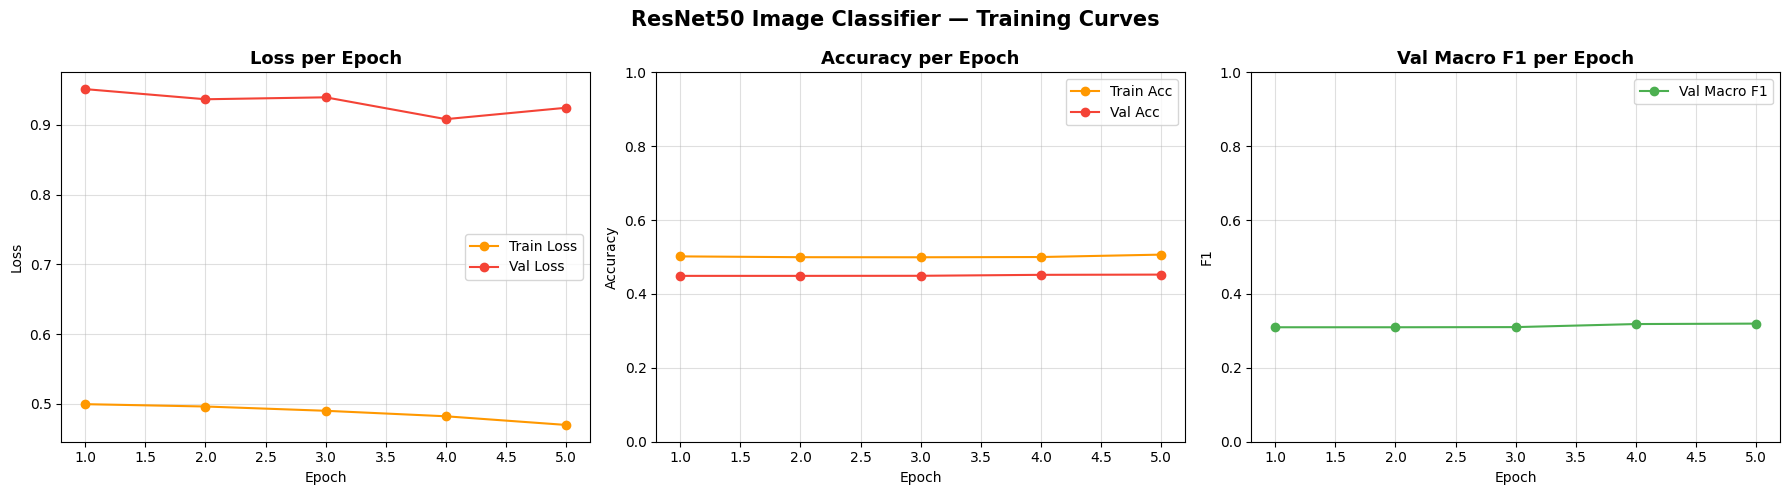

Saved → /content/drive/MyDrive/MMHS150K_CNN/results/training_curves.png


In [11]:
import matplotlib.pyplot as plt
import numpy as np

epochs_ran = range(1, len(history['train_loss']) + 1)
fig, axes  = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(epochs_ran, history['train_loss'], 'o-', color='#FF9800', label='Train Loss')
axes[0].plot(epochs_ran, history['val_loss'],   'o-', color='#F44336', label='Val Loss')
axes[0].set_title('Loss per Epoch', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].grid(True, alpha=0.4)

axes[1].plot(epochs_ran, history['train_acc'], 'o-', color='#FF9800', label='Train Acc')
axes[1].plot(epochs_ran, history['val_acc'],   'o-', color='#F44336', label='Val Acc')
axes[1].set_title('Accuracy per Epoch', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1); axes[1].legend(); axes[1].grid(True, alpha=0.4)

axes[2].plot(epochs_ran, history['val_f1'], 'o-', color='#4CAF50', label='Val Macro F1')
axes[2].set_title('Val Macro F1 per Epoch', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('F1')
axes[2].set_ylim(0, 1); axes[2].legend(); axes[2].grid(True, alpha=0.4)

plt.suptitle('ResNet50 Image Classifier — Training Curves', fontsize=15, fontweight='bold')
plt.tight_layout()
CURVES_PATH = f'{DRIVE_ROOT}/results/training_curves.png'
plt.savefig(CURVES_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved → {CURVES_PATH}")

## Step 9 — Test Set Evaluation

In [12]:
import json as json_mod
from sklearn.metrics import classification_report, confusion_matrix

# Load best checkpoint
ckpt = torch.load(BEST_CKPT, map_location=DEVICE)
model.load_state_dict(ckpt['model_state'])
print(f"Loaded best checkpoint from epoch {ckpt['epoch']}  (val_f1={ckpt['val_f1']:.4f})")

test_loss, test_acc, test_f1, y_true, y_pred = evaluate(test_loader)

report_str  = classification_report(y_true, y_pred, target_names=LABEL_NAMES,
                                    digits=4, zero_division=0)
report_dict = classification_report(y_true, y_pred, target_names=LABEL_NAMES,
                                    digits=4, zero_division=0, output_dict=True)
cm          = confusion_matrix(y_true, y_pred, labels=list(range(N_CLASSES)))

print(f"\n{'='*60}")
print(f"  TEST RESULTS")
print(f"{'='*60}")
print(f"  Accuracy : {test_acc:.4f}")
print(f"  Macro F1 : {test_f1:.4f}")
print(f"\n{report_str}")
print("Confusion matrix:\n", cm)

# Save classification report
REPORT_PATH = f'{DRIVE_ROOT}/results/classification_report.txt'
with open(REPORT_PATH, 'w') as f:
    f.write(f"ResNet50 Image Classifier — {TASK_TAG}\n")
    f.write(f"Best epoch: {ckpt['epoch']} | val_f1: {ckpt['val_f1']:.4f}\n\n")
    f.write(report_str)
    f.write(f"\n\nConfusion Matrix:\n{cm}\n")
print(f"\nSaved → {REPORT_PATH}")

# Save metrics JSON
metrics = {
    'task': TASK_TAG, 'model': 'resnet50',
    'epochs_ran': len(history['train_loss']),
    'best_epoch': ckpt['epoch'], 'best_val_f1': ckpt['val_f1'],
    'history': history,
    'test': {
        'loss': test_loss, 'accuracy': test_acc, 'macro_f1': test_f1,
        'per_class': {
            lbl: {'precision': report_dict.get(lbl, {}).get('precision', 0),
                  'recall':    report_dict.get(lbl, {}).get('recall',    0),
                  'f1':        report_dict.get(lbl, {}).get('f1-score',  0),
                  'support':   report_dict.get(lbl, {}).get('support',   0)}
            for lbl in LABEL_NAMES
        }
    }
}
METRICS_PATH = f'{DRIVE_ROOT}/results/metrics.json'
with open(METRICS_PATH, 'w') as f:
    json_mod.dump(metrics, f, indent=2)
print(f"Saved → {METRICS_PATH}")

Loaded best checkpoint from epoch 5  (val_f1=0.3197)

  TEST RESULTS
  Accuracy : 0.4473
  Macro F1 : 0.3197

              precision    recall  f1-score   support

     NotHate     0.7474    0.0127    0.0250      5574
        Hate     0.4444    0.9946    0.6143      4426

    accuracy                         0.4473     10000
   macro avg     0.5959    0.5037    0.3197     10000
weighted avg     0.6133    0.4473    0.2859     10000

Confusion matrix:
 [[  71 5503]
 [  24 4402]]

Saved → /content/drive/MyDrive/MMHS150K_CNN/results/classification_report.txt
Saved → /content/drive/MyDrive/MMHS150K_CNN/results/metrics.json


## Step 10 — Confusion Matrix & Per-Class F1

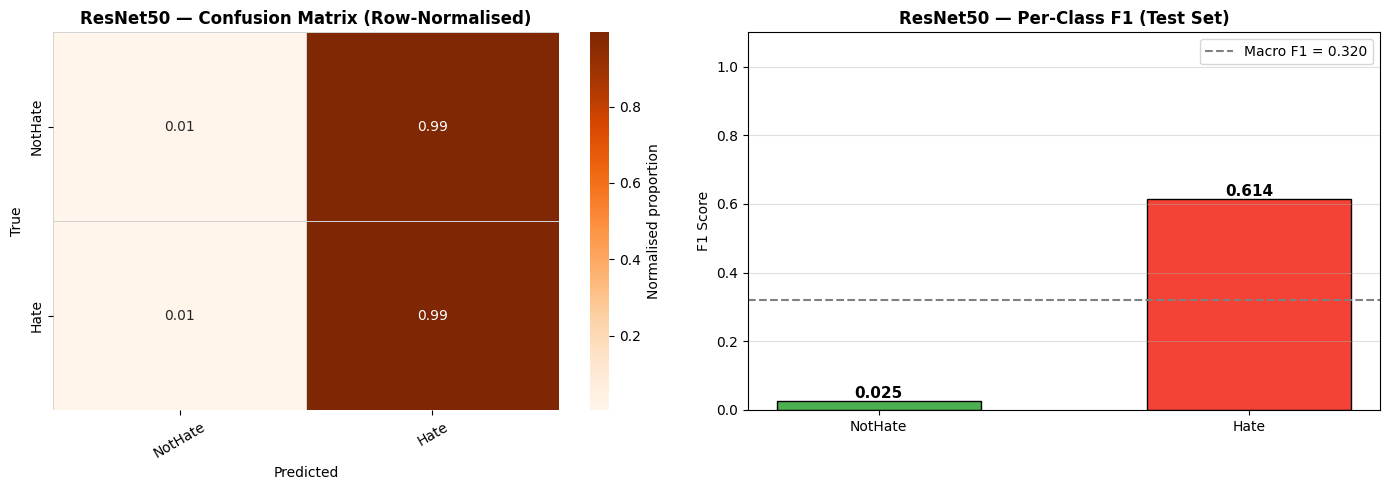

Saved → /content/drive/MyDrive/MMHS150K_CNN/results/confusion_matrix.png
Saved → /content/drive/MyDrive/MMHS150K_CNN/results/per_class_f1.png


In [13]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Confusion matrix ──────────────────────────────────────────────────────────
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES,
            linewidths=0.5, linecolor='lightgray', ax=axes[0],
            cbar_kws={'label': 'Normalised proportion'})
axes[0].set_title('ResNet50 — Confusion Matrix (Row-Normalised)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
axes[0].tick_params(axis='x', rotation=30)

# ── Per-class F1 ──────────────────────────────────────────────────────────────
f1_scores = [report_dict.get(cls, {}).get('f1-score', 0.0) for cls in LABEL_NAMES]
colors    = ['#4CAF50', '#F44336', '#FF9800', '#9C27B0', '#2196F3', '#FF5722'][:N_CLASSES]
bars = axes[1].bar(LABEL_NAMES, f1_scores, color=colors, edgecolor='black', width=0.55)
for bar, val in zip(bars, f1_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')
axes[1].axhline(y=np.mean(f1_scores), color='gray', linestyle='--',
                label=f'Macro F1 = {np.mean(f1_scores):.3f}')
axes[1].set_title('ResNet50 — Per-Class F1 (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1 Score'); axes[1].set_ylim(0, 1.1)
axes[1].legend(); axes[1].grid(axis='y', alpha=0.4)

plt.tight_layout()
CM_PATH = f'{DRIVE_ROOT}/results/confusion_matrix.png'
F1_PATH = f'{DRIVE_ROOT}/results/per_class_f1.png'

# Save both separately too
fig_cm, ax_cm = plt.subplots(figsize=(7, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES,
            linewidths=0.5, ax=ax_cm)
ax_cm.set_title('ResNet50 — Confusion Matrix (Row-Normalised)', fontweight='bold')
ax_cm.set_xlabel('Predicted'); ax_cm.set_ylabel('True')
fig_cm.tight_layout(); fig_cm.savefig(CM_PATH, dpi=150, bbox_inches='tight'); plt.close(fig_cm)

fig_f1, ax_f1 = plt.subplots(figsize=(7, 5))
bars2 = ax_f1.bar(LABEL_NAMES, f1_scores, color=colors, edgecolor='black', width=0.55)
for bar, val in zip(bars2, f1_scores):
    ax_f1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
               f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')
ax_f1.axhline(y=np.mean(f1_scores), color='gray', linestyle='--',
              label=f'Macro F1 = {np.mean(f1_scores):.3f}')
ax_f1.set_title('ResNet50 — Per-Class F1 (Test Set)', fontweight='bold')
ax_f1.set_ylabel('F1 Score'); ax_f1.set_ylim(0, 1.1); ax_f1.legend(); ax_f1.grid(axis='y', alpha=0.4)
fig_f1.tight_layout(); fig_f1.savefig(F1_PATH, dpi=150, bbox_inches='tight'); plt.close(fig_f1)

plt.show()
print(f"Saved → {CM_PATH}")
print(f"Saved → {F1_PATH}")

## Step 11 — Save Full Model to Drive

In [14]:
FULL_SAVE_PATH = f'{DRIVE_ROOT}/checkpoints/cnn_full_classifier.pt'

torch.save({
    'model_state':  model.state_dict(),
    'best_val_f1': best_val_f1,
    'test_accuracy': test_acc,
    'test_macro_f1': test_f1,
    'history': history,
    'config': {
        'num_classes': N_CLASSES,
        'dropout':     DROPOUT,
        'binary':      BINARY,
        'task':        TASK_TAG,
        'label_names': LABEL_NAMES,
        'backbone':    'resnet50',
    }
}, FULL_SAVE_PATH)

print(f"Full model saved → {FULL_SAVE_PATH}")
print(f"\nAll Drive outputs:")
for f in sorted(os.listdir(f'{DRIVE_ROOT}/results')):
    size = os.path.getsize(f'{DRIVE_ROOT}/results/{f}')
    print(f"  results/{f}  ({size/1e3:.0f} KB)")
for f in sorted(os.listdir(f'{DRIVE_ROOT}/checkpoints')):
    size = os.path.getsize(f'{DRIVE_ROOT}/checkpoints/{f}')
    print(f"  checkpoints/{f}  ({size/1e6:.1f} MB)")

Full model saved → /content/drive/MyDrive/MMHS150K_CNN/checkpoints/cnn_full_classifier.pt

All Drive outputs:
  results/classification_report.txt  (0 KB)
  results/confusion_matrix.png  (36 KB)
  results/metrics.json  (1 KB)
  results/per_class_f1.png  (33 KB)
  results/training_curves.png  (85 KB)
  checkpoints/cnn_binary_best.pt  (94.4 MB)
  checkpoints/cnn_full_classifier.pt  (94.4 MB)


## Step 12 — Inference Verification (Reload from Drive)

In [15]:
# Reload the full model from Drive and run inference on 5 test samples
saved = torch.load(FULL_SAVE_PATH, map_location=DEVICE)
cfg   = saved['config']

inference_model = ResNetImageClassifier(
    num_classes=cfg['num_classes'],
    dropout=cfg['dropout'],
    freeze_backbone=False,
).to(DEVICE)
inference_model.load_state_dict(saved['model_state'])
inference_model.eval()

print(f"Reloaded from: {FULL_SAVE_PATH}")
print(f"Config: {cfg}\n")

# Run on 5 test samples
print("Sample predictions on test set:")
print(f"{'Image path':<50}  {'True':>8}  {'Pred':>8}  {'Correct':>8}")
print('-' * 80)

with torch.no_grad():
    for i in range(min(5, len(test_ds))):
        img_path, true_label = test_ds.samples[i]
        try:    img = Image.open(img_path).convert('RGB')
        except: img = Image.new('RGB', (224, 224))

        inp    = EVAL_TF(img).unsqueeze(0).to(DEVICE)
        logits = inference_model(inp)
        probs  = torch.softmax(logits, dim=1)[0]
        pred   = torch.argmax(probs).item()

        fname   = os.path.basename(img_path)
        correct = '✓' if pred == true_label else '✗'
        print(f'{fname:<50}  {LABEL_NAMES[true_label]:>8}  {LABEL_NAMES[pred]:>8}  {correct:>8}')

print(f"\nModel verified ✓")
print(f"Test accuracy : {saved['test_accuracy']:.4f}")
print(f"Test macro F1 : {saved['test_macro_f1']:.4f}")

Reloaded from: /content/drive/MyDrive/MMHS150K_CNN/checkpoints/cnn_full_classifier.pt
Config: {'num_classes': 2, 'dropout': 0.3, 'binary': True, 'task': 'binary', 'label_names': ['NotHate', 'Hate'], 'backbone': 'resnet50'}

Sample predictions on test set:
Image path                                              True      Pred   Correct
--------------------------------------------------------------------------------
1117460975903334410.jpg                                 Hate      Hate         ✓
1043075096544509952.jpg                                 Hate      Hate         ✓
1115669983680454656.jpg                                 Hate      Hate         ✓
1035902082199572486.jpg                                 Hate      Hate         ✓
1036092005741256705.jpg                              NotHate      Hate         ✗

Model verified ✓
Test accuracy : 0.4473
Test macro F1 : 0.3197
